# Preprocessing

In [12]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Paths (Update these to your actual folders)
REAL_CT_PATH = "C:/Users/uppal/OneDrive/Desktop/a/images/real"  # Real images folder
FAKE_CT_PATH = "C:/Users/uppal/OneDrive/Desktop/a/images/fake"  # Fake images folder
OUTPUT_DIR = "processed_lung_ct_vgg"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224  # Standard size for VGGNet (224x224)
CHANNELS = 3    # Ensure 3-channel input for VGGNet

def load_images_from_folder(folder):
    """Loads and processes images for VGGNet."""
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load as is
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize for VGGNet
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB (if needed)
            img = preprocess_input(img)  # Apply VGGNet preprocessing
            images.append(img)
    return np.array(images, dtype=np.float32)

# Load real and fake images
real_images = load_images_from_folder(REAL_CT_PATH)
fake_images = load_images_from_folder(FAKE_CT_PATH)

# Create labels (0 = real, 1 = fake)
real_labels = np.zeros(len(real_images))
fake_labels = np.ones(len(fake_images))

# Combine and shuffle dataset
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)
X, y = shuffle(X, y, random_state=42)

# Train-validation-test split (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save preprocessed data
np.save(os.path.join(OUTPUT_DIR, "X_train.npy"), X_train)
np.save(os.path.join(OUTPUT_DIR, "X_val.npy"), X_val)
np.save(os.path.join(OUTPUT_DIR, "X_test.npy"), X_test)
np.save(os.path.join(OUTPUT_DIR, "y_train.npy"), y_train)
np.save(os.path.join(OUTPUT_DIR, "y_val.npy"), y_val)
np.save(os.path.join(OUTPUT_DIR, "y_test.npy"), y_test)

# Print dataset sizes
print(f"✅ Preprocessing complete! Data saved in `{OUTPUT_DIR}`")
print(f"Real images: {len(real_images)} | Fake images: {len(fake_images)}")
print(f"Training set: {X_train.shape[0]} | Validation set: {X_val.shape[0]} | Testing set: {X_test.shape[0]}")


✅ Preprocessing complete! Data saved in `processed_lung_ct_vgg`
Real images: 900 | Fake images: 900
Training set: 1440 | Validation set: 180 | Testing set: 180


# VggNet16 Training

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import os

# ✅ Load preprocessed dataset
DATASET_DIR = "processed_lung_ct_vgg"
X_train = np.load(os.path.join(DATASET_DIR, "X_train.npy"))
X_test = np.load(os.path.join(DATASET_DIR, "X_test.npy"))
y_train = np.load(os.path.join(DATASET_DIR, "y_train.npy"))
y_test = np.load(os.path.join(DATASET_DIR, "y_test.npy"))

# ✅ Load VGG16 (Pretrained) as a feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# ✅ Define model
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (real or fake)
])

# ✅ Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_lung_ct_vgg16.h5", save_best_only=True, monitor='val_loss')

# ✅ Train model with callbacks
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=16, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

print("✅ Model training complete. Best model saved as best_lung_ct_vgg16.h5")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 75s 1us/step
Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8027 - loss: 0.9399

90/90 ━━━━━━━━━━━━━━━━━━━━ 819s 9s/step - accuracy: 0.8035 - loss: 0.9378 - val_accuracy: 0.8944 - val_loss: 0.7821
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9706 - loss: 0.4760

90/90 ━━━━━━━━━━━━━━━━━━━━ 711s 8s/step - accuracy: 0.9706 - loss: 0.4760 - val_accuracy: 0.9556 - val_loss: 0.5166
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 706s 8s/step - accuracy: 0.9901 - loss: 0.4213 - val_accuracy: 0.9556 - val_loss: 0.5453
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9940 - loss: 0.4006

90/90 ━━━━━━━━━━━━━━━━━━━━ 700s 8s/step - accuracy: 0.9940 - loss: 0.4006 - val_accuracy: 0.9722 - val_loss: 0.4330
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 560s 6s/step - accuracy: 0.9928 - loss: 0.3840 - val_accuracy: 0.9722 - val_loss: 0.4462
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - accuracy: 0.9910 - loss: 0.3793 - val_accuracy: 0.9611 - val_loss: 0.4566
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 1.0000 - loss: 0.3446

90/90 ━━━━━━━━━━━━━━━━━━━━ 518s 6s/step - accuracy: 1.0000 - loss: 0.3446 - val_accuracy: 0.9667 - val_loss: 0.3983
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9989 - loss: 0.3336

90/90 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step - accuracy: 0.9989 - loss: 0.3335 - val_accuracy: 0.9667 - val_loss: 0.3862
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9990 - loss: 0.3189

90/90 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - accuracy: 0.9990 - loss: 0.3189 - val_accuracy: 0.9722 - val_loss: 0.3832
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9985 - loss: 0.3077

90/90 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - accuracy: 0.9985 - loss: 0.3077 - val_accuracy: 0.9611 - val_loss: 0.3709
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - accuracy: 0.9978 - loss: 0.2963 - val_accuracy: 0.9556 - val_loss: 0.4173
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - accuracy: 0.9989 - loss: 0.2839 - val_accuracy: 0.9611 - val_loss: 0.3843
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 699s 8s/step - accuracy: 0.9931 - loss: 0.2864 - val_accuracy: 0.9722 - val_loss: 0.4023
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 699s 8s/step - accuracy: 0.9942 - loss: 0.2716 - val_accuracy: 0.9833 - val_loss: 0.3719
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9999 - loss: 0.2552

90/90 ━━━━━━━━━━━━━━━━━━━━ 733s 8s/step - accuracy: 0.9999 - loss: 0.2552 - val_accuracy: 0.9611 - val_loss: 0.3681
Epoch 16/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9977 - loss: 0.2499

90/90 ━━━━━━━━━━━━━━━━━━━━ 706s 8s/step - accuracy: 0.9977 - loss: 0.2499 - val_accuracy: 0.9722 - val_loss: 0.3261
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 700s 8s/step - accuracy: 0.9941 - loss: 0.2559 - val_accuracy: 0.9722 - val_loss: 0.3276
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9919 - loss: 0.2469

90/90 ━━━━━━━━━━━━━━━━━━━━ 751s 8s/step - accuracy: 0.9920 - loss: 0.2468 - val_accuracy: 0.9778 - val_loss: 0.2863
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 926s 10s/step - accuracy: 0.9952 - loss: 0.2270 - val_accuracy: 0.9722 - val_loss: 0.2875
Epoch 20/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9975 - loss: 0.2157

90/90 ━━━━━━━━━━━━━━━━━━━━ 646s 7s/step - accuracy: 0.9975 - loss: 0.2156 - val_accuracy: 0.9722 - val_loss: 0.2788
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9992 - loss: 0.2058

90/90 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - accuracy: 0.9992 - loss: 0.2058 - val_accuracy: 0.9722 - val_loss: 0.2742
Epoch 22/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 606s 7s/step - accuracy: 0.9974 - loss: 0.2065 - val_accuracy: 0.9667 - val_loss: 0.3065
Epoch 23/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 601s 7s/step - accuracy: 0.9969 - loss: 0.1958 - val_accuracy: 0.9722 - val_loss: 0.2752
Epoch 24/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.9992 - loss: 0.1867 - val_accuracy: 0.9667 - val_loss: 0.2902
Epoch 25/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9992 - loss: 0.1812

90/90 ━━━━━━━━━━━━━━━━━━━━ 710s 8s/step - accuracy: 0.9992 - loss: 0.1812 - val_accuracy: 0.9667 - val_loss: 0.2721
Epoch 26/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9974 - loss: 0.1761

90/90 ━━━━━━━━━━━━━━━━━━━━ 750s 8s/step - accuracy: 0.9974 - loss: 0.1761 - val_accuracy: 0.9722 - val_loss: 0.2660
Epoch 27/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9995 - loss: 0.1663

90/90 ━━━━━━━━━━━━━━━━━━━━ 780s 9s/step - accuracy: 0.9995 - loss: 0.1663 - val_accuracy: 0.9667 - val_loss: 0.2576
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 703s 8s/step - accuracy: 0.9941 - loss: 0.1714 - val_accuracy: 0.9722 - val_loss: 0.2731
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 692s 8s/step - accuracy: 0.9989 - loss: 0.1572 - val_accuracy: 0.9778 - val_loss: 0.2731
Epoch 30/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9964 - loss: 0.1589

90/90 ━━━━━━━━━━━━━━━━━━━━ 708s 8s/step - accuracy: 0.9964 - loss: 0.1590 - val_accuracy: 0.9833 - val_loss: 0.2259
✅ Model training complete. Best model saved as best_lung_ct_vgg16.h5


In [6]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("best_lung_ct_vgg16.h5")

# Print model summary to confirm it's loaded
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,238,083 (81.02 MB)

 Trainable params: 6,473,217 (24.69 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

 Optimizer params: 2 (12.00 B)

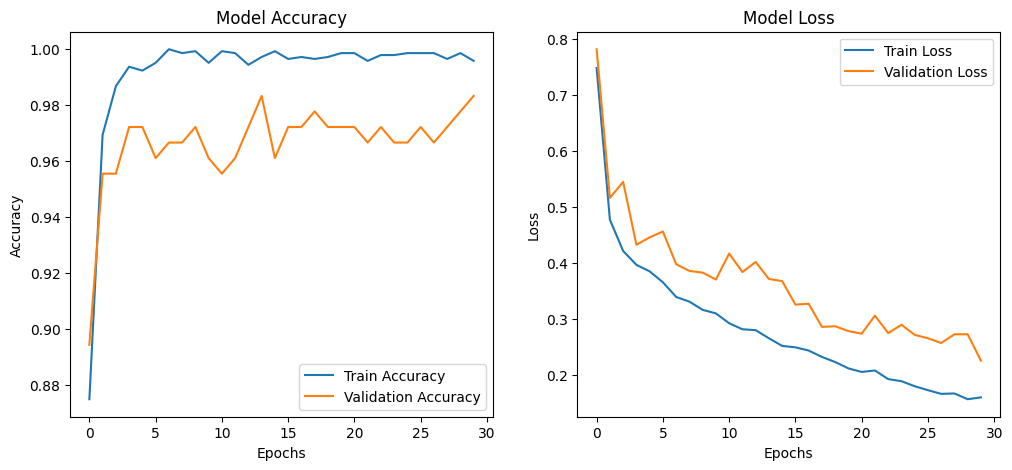

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 74s 12s/step
Classification Report:
               precision    recall  f1-score   support

        Real       0.97      1.00      0.98        90
        Fake       1.00      0.97      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



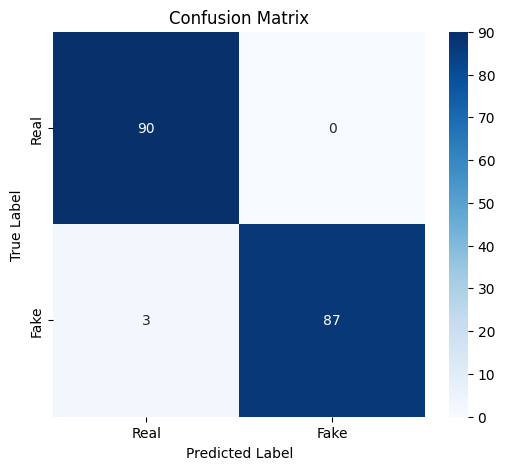

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [7]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

# ✅ Load the trained VGG16 model
MODEL_PATH = "best_lung_ct_vgg16.h5"  # Update to VGG16 model path
model = load_model(MODEL_PATH, compile=False)

# VGG16 expects 224x224x3 input
IMG_SIZE = 224  
CHANNELS = 3    

# ✅ Function to preprocess a single image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"❌ Image not found: {image_path}")

    img = cv2.imread(image_path)  # Load image
    if img is None:
        raise ValueError(f"❌ Unable to load image: {image_path}")

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (VGG16 expects RGB)
    img = preprocess_input(img)  # Apply VGG16 preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# ✅ Function to make a prediction
def predict_image(image_path):
    try:
        img = preprocess_image(image_path)  # Preprocess input image
        prediction = model.predict(img)[0][0]  # Get prediction (single value)
        
        if prediction < 0.5:
            result = "✅ Real CT Scan (Class 0)"
        else:
            result = "❌ Fake CT Scan (Class 1)"
        
        print(f"Prediction: {prediction:.4f} --> {result}")
    except Exception as e:
        print(f"Error: {e}")

# ✅ Example usage
IMAGE_PATH = "C:/Users/uppal/OneDrive/Desktop/DL/f3.png"  # Change this to your test image path
predict_image(IMAGE_PATH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: 1.0000 --> ❌ Fake CT Scan (Class 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Prediction for C:/Users/uppal/OneDrive/Desktop/DL/r1.png: 0.0000 --> ✅ Real CT Scan (Class 0)


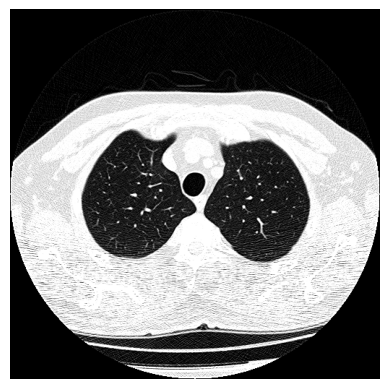

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
Prediction for C:/Users/uppal/OneDrive/Desktop/DL/r2.png: 0.0000 --> ✅ Real CT Scan (Class 0)


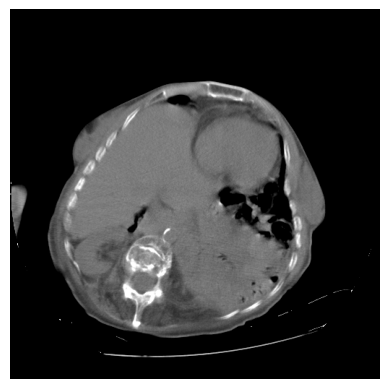

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
Prediction for C:/Users/uppal/OneDrive/Desktop/DL/r3.png: 0.0000 --> ✅ Real CT Scan (Class 0)


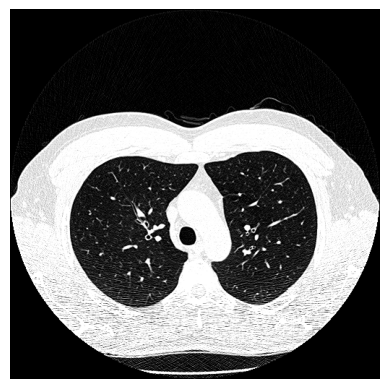

In [6]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
import matplotlib.pyplot as plt  # For displaying images

# ✅ Load the trained VGG16 model
MODEL_PATH = "best_lung_ct_vgg16.h5"  # Update to VGG16 model path
model = load_model(MODEL_PATH, compile=False)

# VGG16 expects 224x224x3 input
IMG_SIZE = 224  
CHANNELS = 3    

# ✅ Function to preprocess a single image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"❌ Image not found: {image_path}")

    img = cv2.imread(image_path)  # Load image
    if img is None:
        raise ValueError(f"❌ Unable to load image: {image_path}")

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (VGG16 expects RGB)
    img = preprocess_input(img)  # Apply VGG16 preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# ✅ Function to make a prediction
def predict_image(image_path):
    try:
        img = preprocess_image(image_path)  # Preprocess input image
        prediction = model.predict(img)[0][0]  # Get prediction (single value)
        
        if prediction < 0.5:
            result = "✅ Real CT Scan (Class 0)"
        else:
            result = "❌ Fake CT Scan (Class 1)"
        
        print(f"Prediction for {image_path}: {prediction:.4f} --> {result}")
        
        # Plot the image after prediction
        img_to_show = cv2.imread(image_path)  # Load the image to show
        img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        plt.imshow(img_to_show)  # Display image
        plt.axis('off')  # Turn off axis labels
        plt.show()  # Show image
        
    except Exception as e:
        print(f"Error: {e}")

# ✅ Example usage for 3 images
IMAGE_PATHS = [
    "C:/Users/uppal/OneDrive/Desktop/DL/r1.png",  # First image path
    "C:/Users/uppal/OneDrive/Desktop/DL/r2.png",  # Second image path
    "C:/Users/uppal/OneDrive/Desktop/DL/r3.png"   # Third image path
]

# Loop through the images and predict
for img_path in IMAGE_PATHS:
    predict_image(img_path)
